# Credit Card Fraud Detection

The objective is to create the best classifier for credit card fraud detection.
 
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where there are 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 

It contains only numerical input variables which are the result of a PCA transformation as due to confidentiality issues, original features and more background information about the data cannot be provided.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# import kaggle data
df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Processing

Time not necessary for classification so can be removed from the dataset :

In [3]:
df = df.drop("Time", axis=1)

Standardise the 'Amount' feature before modelling using sklearn StandardScaler function

In [4]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [5]:
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape (-1,1))

<AxesSubplot:xlabel='Class', ylabel='count'>

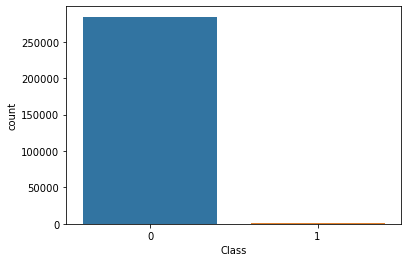

In [6]:
sns.countplot(x="Class", data=df)

In [7]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
# define X and Y
X = df.drop(['Class'],axis=1)
Y = df['Class']

In [164]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

### Undersampling to balance classes

In [12]:
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5)

In [13]:
X_under, Y_under = undersample.fit_resample(X, Y)

Text(0.5, 1.0, 'After')

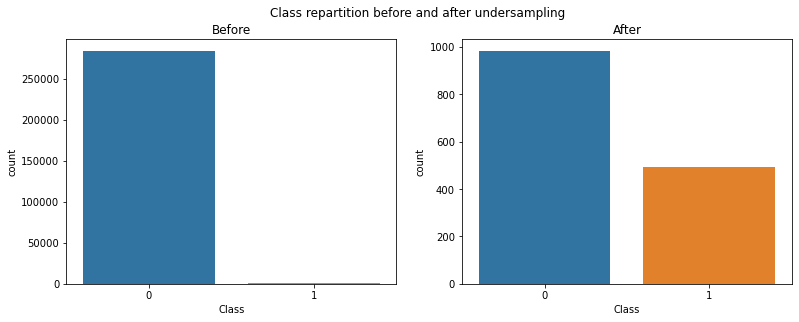

In [14]:
test = pd.DataFrame(Y_under, columns = ['Class'])
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=df, ax=axs[0])
sns.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.3, random_state=50)

## Modelling

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score

## 1. Logistic Regression

In [17]:
#train the model
model1 = LogisticRegression(random_state=50)
logit = model1.fit(X_train, y_train)

In [18]:
#predictions
y_pred_logit = model1.predict(X_test) 

In [19]:
#scores
print("Accuracy Logit:",metrics.accuracy_score(y_test, y_pred_logit))
print("Precision Logit:",metrics.precision_score(y_test, y_pred_logit))
print("Recall Logit:",metrics.recall_score(y_test, y_pred_logit))
print("F1 Score Logit:",metrics.f1_score(y_test, y_pred_logit))

Accuracy Logit: 0.9757967299837318
Precision Logit: 0.06041189931350115
Recall Logit: 0.8979591836734694
F1 Score Logit: 0.11320754716981134


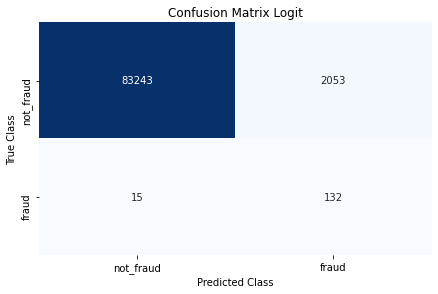

In [20]:
matrix_logit = confusion_matrix(y_test, y_pred_logit)
cm_logit = pd.DataFrame(matrix_logit, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_logit, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Logit"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [21]:
#AUC
y_pred_logit_proba = model1.predict_proba(X_test)[::,1]
fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test,  y_pred_logit_proba)
auc_logit = metrics.roc_auc_score(y_test, y_pred_logit_proba)
print("AUC Logistic Regression :", auc_logit)

AUC Logistic Regression : 0.9786723097605203


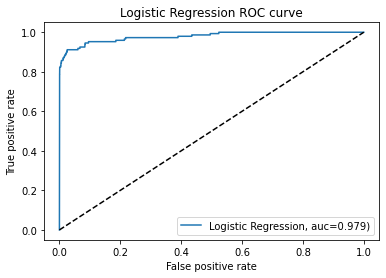

In [22]:
#ROC
plt.plot(fpr_logit,tpr_logit,label="Logistic Regression, auc={:.3f})".format(auc_logit))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc=4)
plt.show()

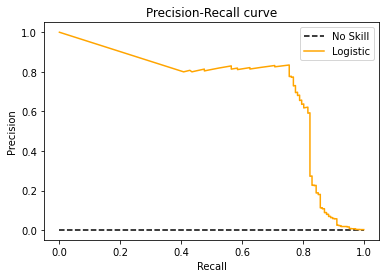

In [23]:
logit_precision, logit_recall, _ = precision_recall_curve(y_test, y_pred_logit_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(logit_recall, logit_precision, color='orange', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## 2. SVM

In [24]:
model2 = SVC(probability=True, random_state=50)
svm = model2.fit(X_train, y_train)

In [26]:
y_pred_svm = model2.predict(X_test)

In [27]:
print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision SVM:",metrics.precision_score(y_test, y_pred_svm))
print("Recall SVM:",metrics.recall_score(y_test, y_pred_svm))
print("F1 Score SVM:",metrics.f1_score(y_test, y_pred_svm))

Accuracy SVM: 0.9817539178165561
Precision SVM: 0.07367149758454106
Recall SVM: 0.8299319727891157
F1 Score SVM: 0.1353300055463117


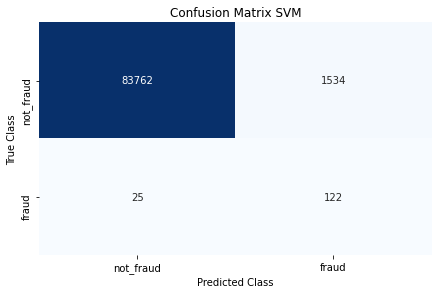

In [28]:
matrix_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm = pd.DataFrame(matrix_svm, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_svm, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix SVM"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [29]:
y_pred_svm_proba = model2.predict_proba(X_test)[::,1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm_proba)
print("AUC SVM :", auc_svm)

AUC SVM : 0.9548405743839461


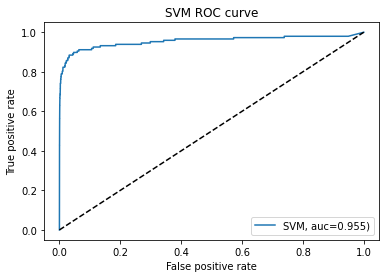

In [30]:
plt.plot(fpr_svm,tpr_svm,label="SVM, auc={:.3f})".format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SVM ROC curve')
plt.legend(loc=4)
plt.show()

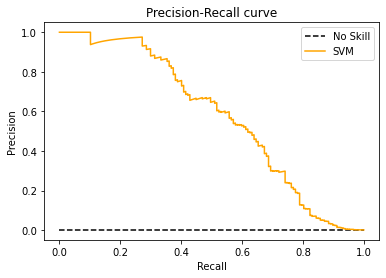

In [31]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(svm_recall, svm_precision, color='orange', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## 3. Random Forest

In [32]:
model3 = RandomForestClassifier(random_state=2)
rf = model3.fit(X_train, y_train)

In [33]:
y_pred_rf = model3.predict(X_test)

In [34]:
print("Accuracy RF:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision RF:",metrics.precision_score(y_test, y_pred_rf))
print("Recall RF:",metrics.recall_score(y_test, y_pred_rf))
print("F1 Score RF:",metrics.f1_score(y_test, y_pred_rf))

Accuracy RF: 0.9993914071369217
Precision RF: 0.8368794326241135
Recall RF: 0.8027210884353742
F1 Score RF: 0.8194444444444443


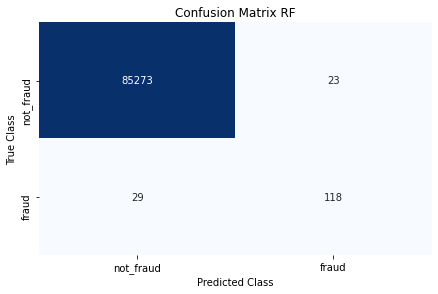

In [35]:
matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf = pd.DataFrame(matrix_rf, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_rf, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix RF"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [36]:
y_pred_rf_proba = model3.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
auc_rf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
print("AUC Random Forest :", auc_rf)

AUC Random Forest : 0.9703980823242823


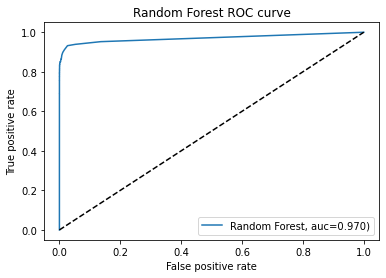

In [37]:
plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc={:.3f})".format(auc_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve')
plt.legend(loc=4)
plt.show()

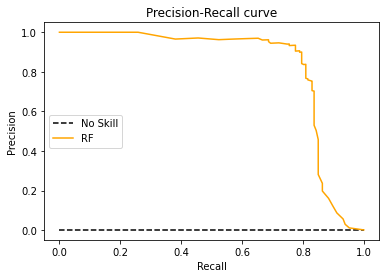

In [38]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_pred_rf_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(rf_recall, rf_precision, color='orange', label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## 4. XGBoost

In [39]:
model4 = XGBClassifier(random_state=2)
xgb = model4.fit(X_train, y_train)

C:\Users\aisling.mac.ardle\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
y_pred_xgb = model4.predict(X_test) 

In [41]:
print("Accuracy XGB:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision XGB:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall XGB:",metrics.recall_score(y_test, y_pred_xgb))
print("F1 Score XGB:",metrics.f1_score(y_test, y_pred_xgb))

Accuracy XGB: 0.9991105181231933
Precision XGB: 0.7177914110429447
Recall XGB: 0.7959183673469388
F1 Score XGB: 0.7548387096774193


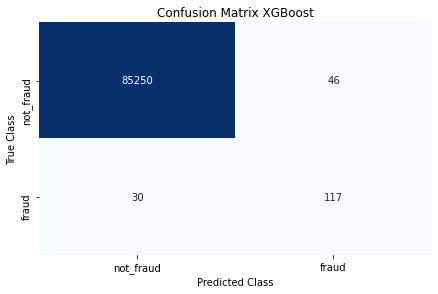

In [42]:
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb = pd.DataFrame(matrix_xgb, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_xgb, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix XGBoost"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [43]:
y_pred_xgb_proba = model4.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_xgb_proba)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_xgb_proba)
print("AUC XGBoost :", auc_xgb)

AUC XGBoost : 0.9770012582035252


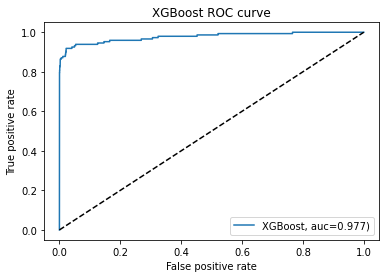

In [44]:
plt.plot(fpr_xgb,tpr_xgb,label="XGBoost, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve')
plt.legend(loc=4)
plt.show()

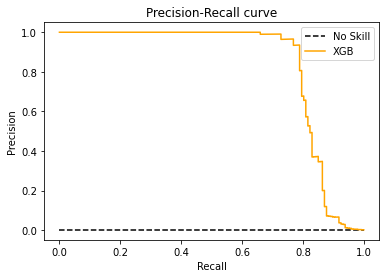

In [45]:
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_xgb_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## 5. Isolation Forest

Unsupervised algorithm for anomaly detetion that works on principle of isolating anomalies. Instead of trying to build a model of normal instances, it explicitly isolates anomalous points in the dataset.

In [269]:
fraud = df[df['Class'] == 1] # Number of fraudulent transactions
valid = df[df['Class'] == 0] # Number of valid transactions
outlier_fraction = len(fraud)/float(len(valid))
print('Positive Rate: ', outlier_fraction)

Positive Rate:  0.0017304750013189597


In [270]:
valid = df[df.Class==0].drop(['Class'],axis=1)
fraud = df[df.Class==1].drop(['Class'],axis=1)
valid_train, valid_test = train_test_split(valid, test_size=0.30, random_state=50)

In [271]:
model5 = IsolationForest(n_estimators=200,#contamination = 0.15, #outlier_fraction, #max_samples= len(X_train),# ,
                         random_state=50)
model5.fit(valid_train)
Valid_pred = model5.predict(valid_test)
Fraud_pred = model5.predict(fraud)

In [272]:
print("Valid cases accuracy:", list(Valid_pred).count(1)/Valid_pred.shape[0])
print("Fraud Cases accuracy:", list(Fraud_pred).count(-1)/Fraud_pred.shape[0])

Valid cases accuracy: 0.9607245442288528
Fraud Cases accuracy: 0.8292682926829268


In [286]:
y_pred_if = np.concatenate([Valid_pred, Fraud_pred])
y_test = np.concatenate([[1] * len(Valid_pred),[-1] * len(Fraud_pred)])

In [287]:
print("Accuracy Isolation Forest:",metrics.accuracy_score(y_test, y_pred_if))
print("Precision Isolation Forest:",metrics.precision_score(y_test, y_pred_if))
print("Recall Isolation Forest:",metrics.recall_score(y_test, y_pred_if))
print("F1 Score Isolation Forest:",metrics.f1_score(y_test, y_pred_if))

Accuracy Isolation Forest: 0.9599706249198596
Precision Isolation Forest: 0.9989759719123724
Recall Isolation Forest: 0.9607245442288528
F1 Score Isolation Forest: 0.9794769429370563


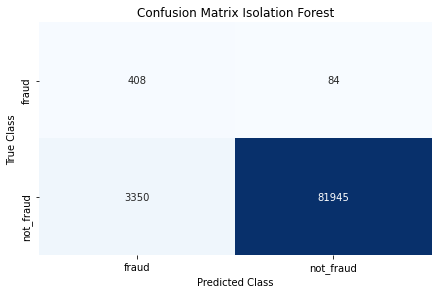

In [288]:
matrix_if = confusion_matrix(y_test, y_pred_if)
cm_if = pd.DataFrame(matrix_if, index=['fraud', 'not_fraud'], columns=['fraud', 'not_fraud'])

sns.heatmap(cm_if, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Isolation Forest"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [290]:
y_pred_if = np.concatenate([valid_test, fraud])
y_pred_if_proba = abs(model5.score_samples(y_pred_if))
fpr_if, tpr_if, _ = metrics.roc_curve(y_test,  y_pred_if_proba)
auc_if = metrics.roc_auc_score(y_test, y_pred_if_proba)
print("AUC Isolation Forest :", auc_if)

AUC Isolation Forest : 0.9464997614686858


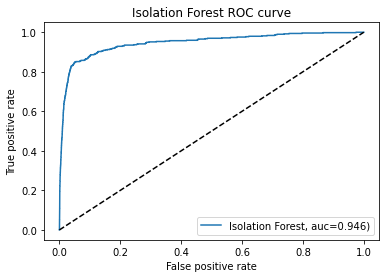

In [291]:
plt.plot(fpr_if,tpr_if,label="Isolation Forest, auc={:.3f})".format(auc_if))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Isolation Forest ROC curve')
plt.legend(loc=4)
plt.show()

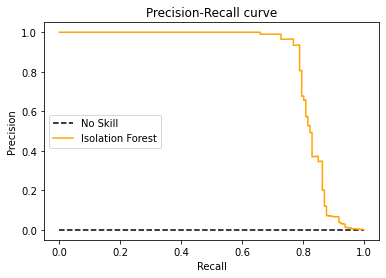

In [292]:
if_precision, if_recall, _ = precision_recall_curve(y_test, y_pred_if_proba)
no_skill = len(y_test[y_test==-1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='Isolation Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()